In [55]:
import pandas as pd
import numpy as np
# %matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt

import datetime
from datetime import timedelta

import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(10, 4)})

## Import Austin 5 min weather data

In [ ]:
weather = pd.read_csv("./austin_5min_weather/austin_5min_weather.csv")

In [ ]:
weather.head(10)

In [ ]:
weather.tail(10)

## Clean precipitation data, precipitation is in mm

In [ ]:
mask = weather.PRECIPITATION > 2000
column_name = 'PRECIPITATION'
weather.loc[mask, column_name] = 0

mask = weather.PRECIPITATION < -2000
column_name = 'PRECIPITATION'
weather.loc[mask, column_name] = 0

## Import and clean hourly weather data

In [3]:
hourly_weather = pd.read_csv('./austin_hourly_weather/KAUS_06_29_2018.csv')
hourly_weather.drop(hourly_weather.tail(1).index,inplace=True)

In [4]:
hourly_weather.head(10)

,Source,Station,Date,Time,UTC Time,Temp (F),Precip (in)
0,ish,KAUS,06/29/2018,01:00,05:53,80.0,'-
1,ish,KAUS,06/29/2018,02:00,06:53,80.0,'-
2,ish,KAUS,06/29/2018,03:00,07:53,79.0,'-
3,ish,KAUS,06/29/2018,04:00,08:53,78.0,'-
4,ish,KAUS,06/29/2018,05:00,09:53,77.0,'-
5,ish,KAUS,06/29/2018,06:00,10:53,77.0,'-
6,ish,KAUS,06/29/2018,07:00,11:53,79.0,'-
7,ish,KAUS,06/29/2018,08:00,12:53,83.0,'-
8,ish,KAUS,06/29/2018,09:00,13:53,85.0,'-
9,ish,KAUS,06/29/2018,10:00,14:53,88.0,'-


In [5]:
hourly_weather.dtypes

Source         object
Station        object
Date           object
Time           object
UTC Time       object
Temp (F)       object
Precip (in)    object
dtype: object

### Convert weather dataframe to time-based indexing

In [6]:
hourly_weather['Precip (in)'] = (pd.to_numeric(hourly_weather['Precip (in)'],errors='coerce').fillna(0))

In [7]:
hourly_weather['datetime'] = hourly_weather['Date'] + " " + hourly_weather['Time']
hourly_weather['datetime'] = pd.to_datetime(hourly_weather['datetime'])

In [8]:
hourly_weather = hourly_weather.set_index('datetime')

## Plot Hourly Precipitation (in)

<IPython.core.display.Javascript object>


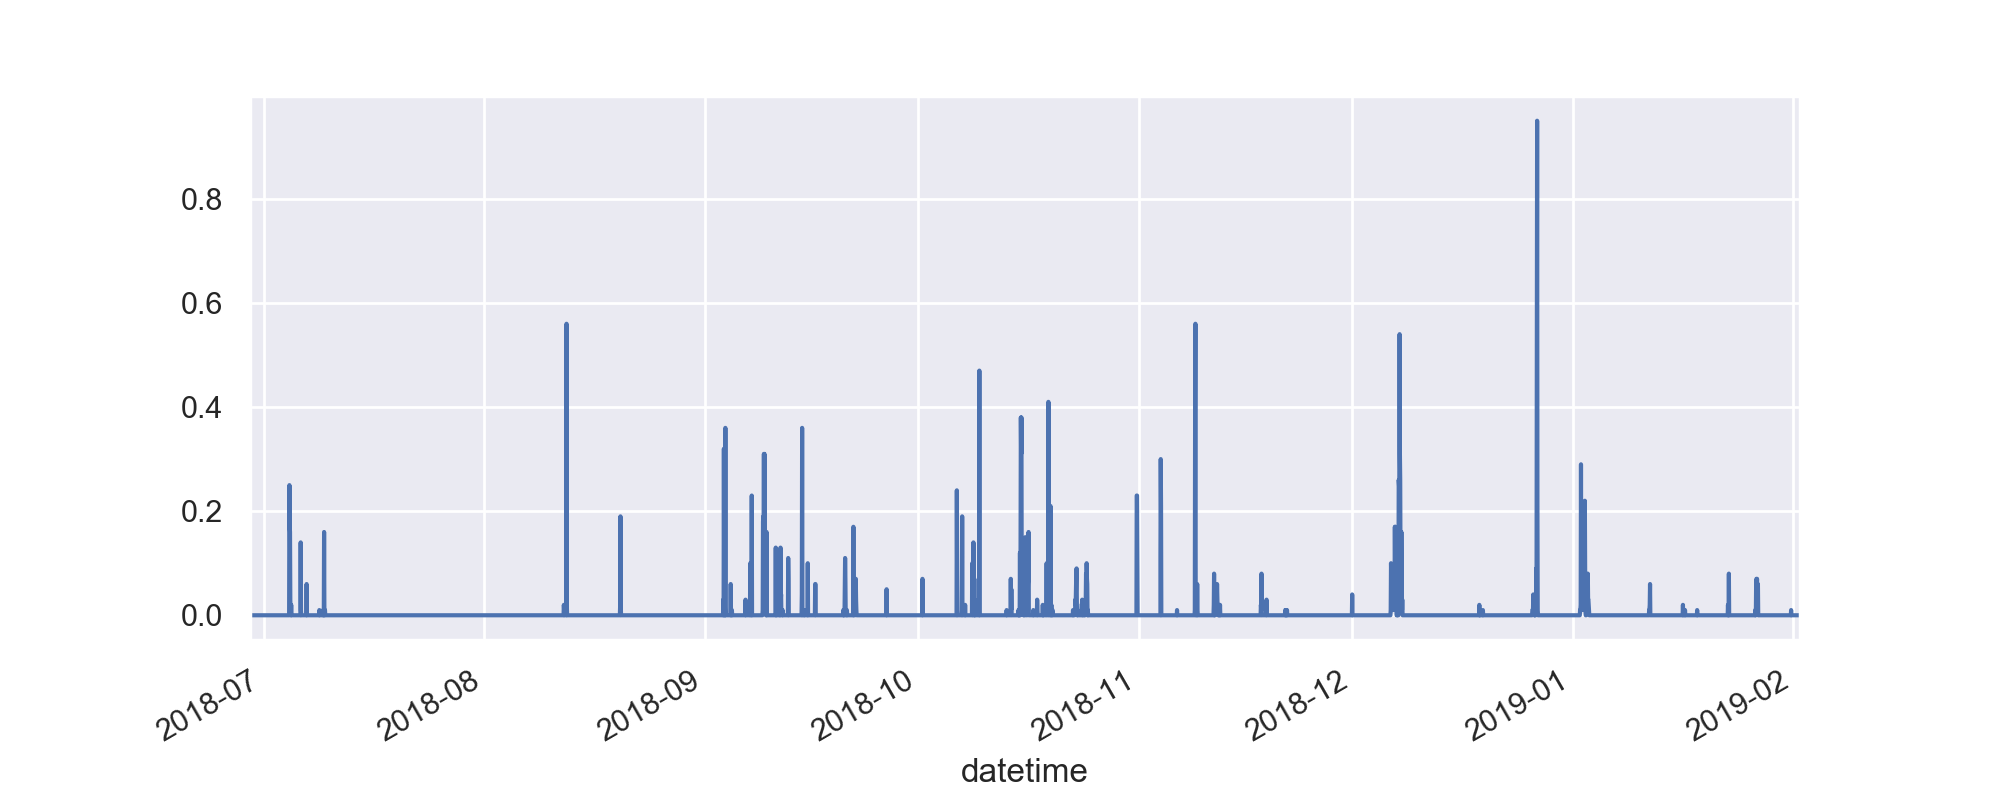

In [67]:
%matplotlib notebook
hourly_weather['Precip (in)'].plot()

## Import, clean, and create hourly scooter ride dataset

In [10]:
dockless = pd.read_csv("Austin_Dockless_Vehicle_Trips.csv")

/anaconda3/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
dockless['Start Time'] = pd.to_datetime(dockless['Start Time'], format='%m/%d/%Y %I:%M:%S %p')
dockless['End Time'] = pd.to_datetime(dockless['End Time'], format='%m/%d/%Y %I:%M:%S %p')
dockless['Modified Date'] = pd.to_datetime(dockless['End Time'], format='%m/%d/%Y %I:%M:%S %p')

dockless['Trip Distance (Miles)'] = (dockless['Trip Distance']/1000)*0.621371

dockless.rename(columns={'Trip Duration': 'Trip Duration (Seconds)', 'Trip Distance': 'Trip Distance (Meters)'}, inplace = True)
dockless.drop(dockless[dockless['Trip Distance (Meters)'] < 0].index, inplace=True)
dockless.drop(dockless[dockless['Trip Distance (Miles)'] > 75].index, inplace=True)

dockless.dropna(inplace = True)

In [12]:
date_rng = pd.date_range(start='6/29/2018', end='2/12/2019').tolist()
date_rng_hourly = pd.date_range(start='6/29/2018', end='2/13/2019', freq='H', closed='left').tolist()
hourly_rides = pd.DataFrame(date_rng_hourly, columns=['date'])
hourly_rides = hourly_rides.set_index('date')

In [13]:
num_hours = len(date_rng)*24
ride_counts = np.zeros(num_hours)
i = 0
for date in date_rng:
    hour = 0
    while hour < 24:
        start_date = date + timedelta(hours=hour)
        end_date = start_date + timedelta(hours=1)
        mask = (dockless['Start Time'] > start_date) & (dockless['Start Time'] <= end_date)
        day_rides = dockless.loc[mask]
        num_rides = day_rides.shape[0]
        ride_counts[i] = num_rides
        i = i + 1
        hour = hour + 1
ride_counts

array([5., 6., 1., ..., 0., 0., 0.])

<IPython.core.display.Javascript object>


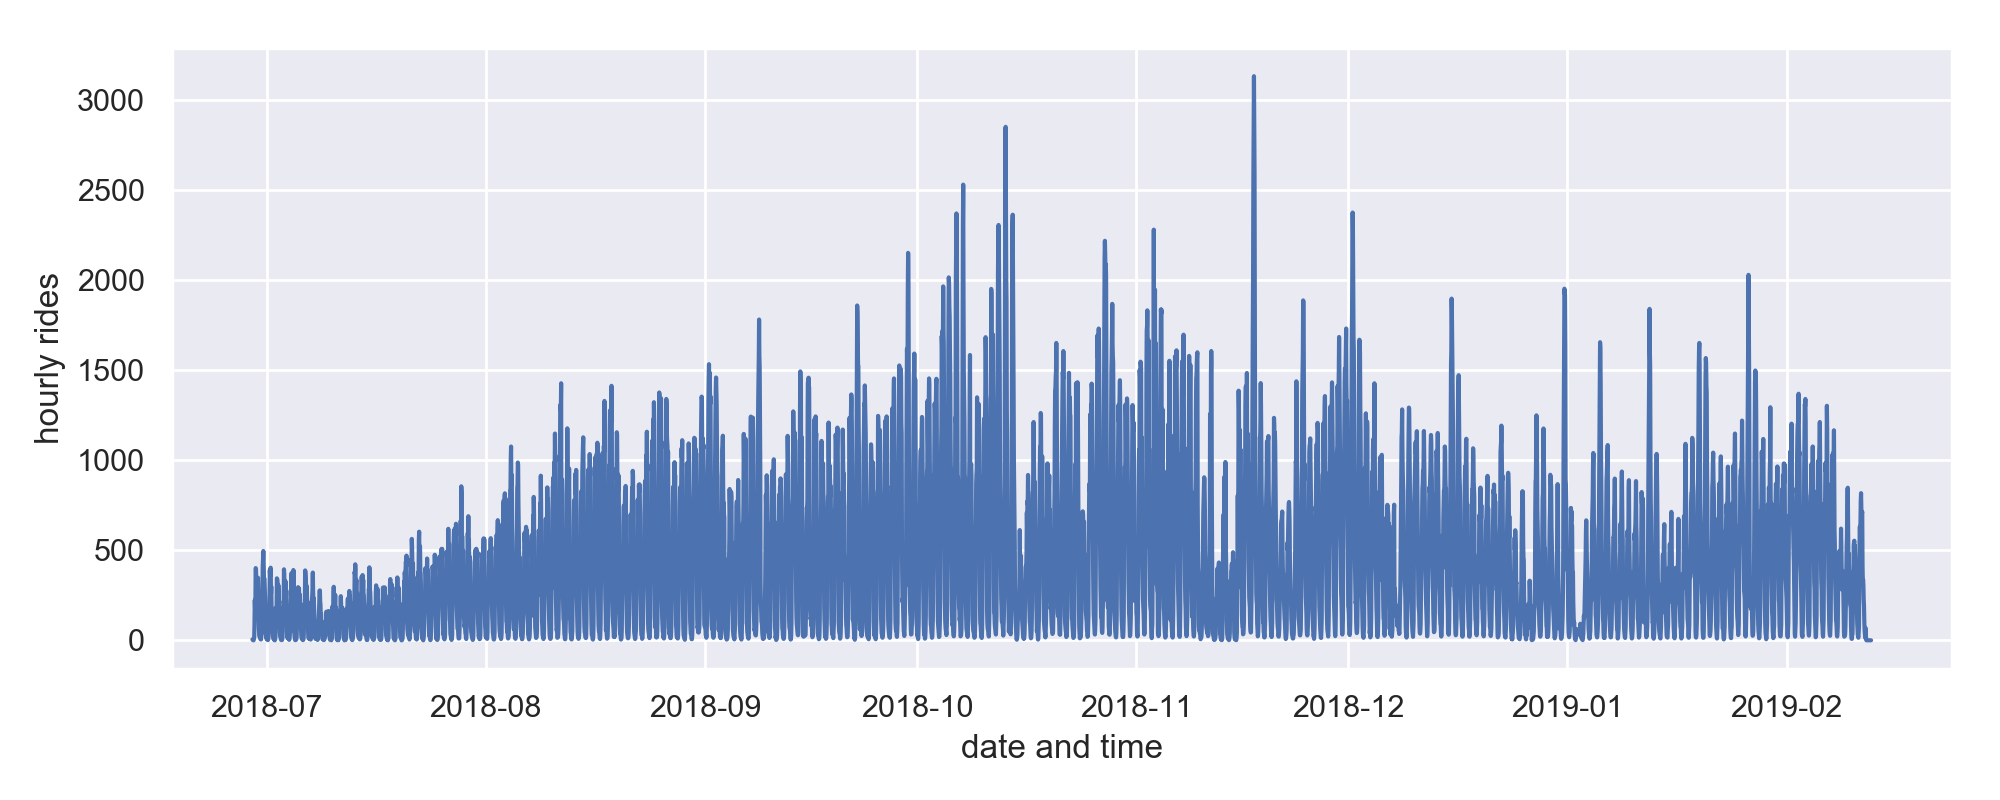

In [68]:
%matplotlib notebook
fig, ax1 = plt.subplots()
hourly_rides['ridecount'] = ride_counts
ax1.plot(hourly_rides.index, hourly_rides['ridecount'])
ax1.set_ylabel('hourly rides')
ax1.set_xlabel('date and time')
# hourly_rides['ridecount'].plot()
fig.tight_layout() 
plt.show()

### Demand dips on Mondays, and is highest on Thursdays, Fridays, and Saturdays

Looking at demand on an hourly basis yields some interesting results. We see that on Monday through thursday, there are three spikes in demand: 8am, 12pm, and 4-7pm. Typically the spikes increase in size as the day goes on.


On Fridays and Saturdays, the largest peak typically occurrs between 6pm and 9pm. On saturdays, the peak tends to occurr closer to 9pm than 6pm.

Intuitively, these make sense. Riders want to get to work, go to lunch, and leave work on scooters. Then scooter demand picks up on Friday and Saturday evenings when many people are out and about.

## Combine hourly scooter rides with weather data

In [18]:
df1 = hourly_weather.join(hourly_rides, how='outer')
df1 = df1.dropna()

## Plot hourly precipitation on top of hourly scooter rides
### In many instances, it appears that a drop in demand can be explained by significant precipitation

<IPython.core.display.Javascript object>


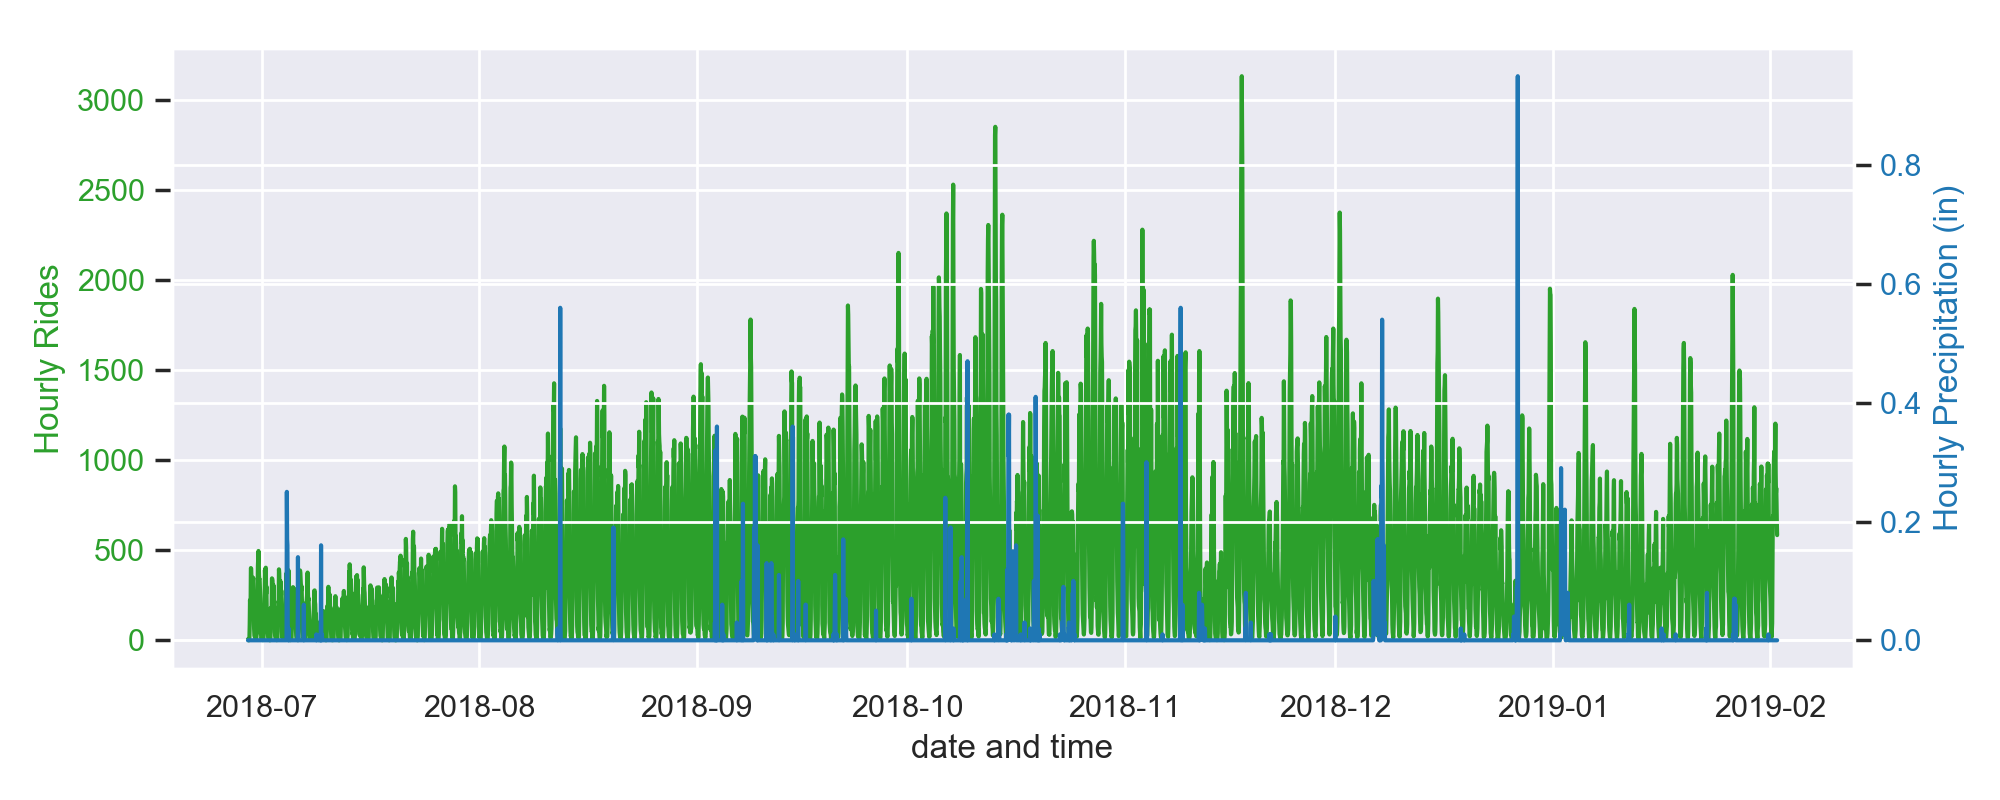

In [69]:
%matplotlib notebook
data1 = df1['ridecount']
data2 = df1['Precip (in)']
t = df1.index

fig, ax1 = plt.subplots()
# ax1.set_facecolor('white')

color = 'tab:green'
ax1.set_xlabel('date and time')
ax1.set_ylabel('Hourly Rides', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Hourly Precipitation (in)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## Import accident data and create hourly accidents column

In [24]:
accidents = pd.read_csv('scooter_accidents.csv')

In [33]:
accidents['Time Phone Pickup'] = pd.to_datetime(accidents['Time Phone Pickup'], format='%m/%d/%y %H:%M')
accidents.sort_values(by=['Time Phone Pickup'], inplace=True, ascending=True)

In [35]:
num_hours = len(date_rng)*24
accident_counts = np.zeros(num_hours)
i = 0
for date in date_rng:
    hour = 0
    while hour < 24:
        start_date = date + timedelta(hours=hour)
        end_date = start_date + timedelta(hours=1)
        mask = (accidents['Time Phone Pickup'] > start_date) & (accidents['Time Phone Pickup'] <= end_date)
        day_accidents = accidents.loc[mask]
        num_accidents = day_accidents.shape[0]
        accident_counts[i] = num_accidents
        i = i + 1
        hour = hour + 1
accident_counts

array([0., 0., 0., ..., 0., 0., 0.])

## Combine accident data with hourly rides and hourly precipitation data

<IPython.core.display.Javascript object>


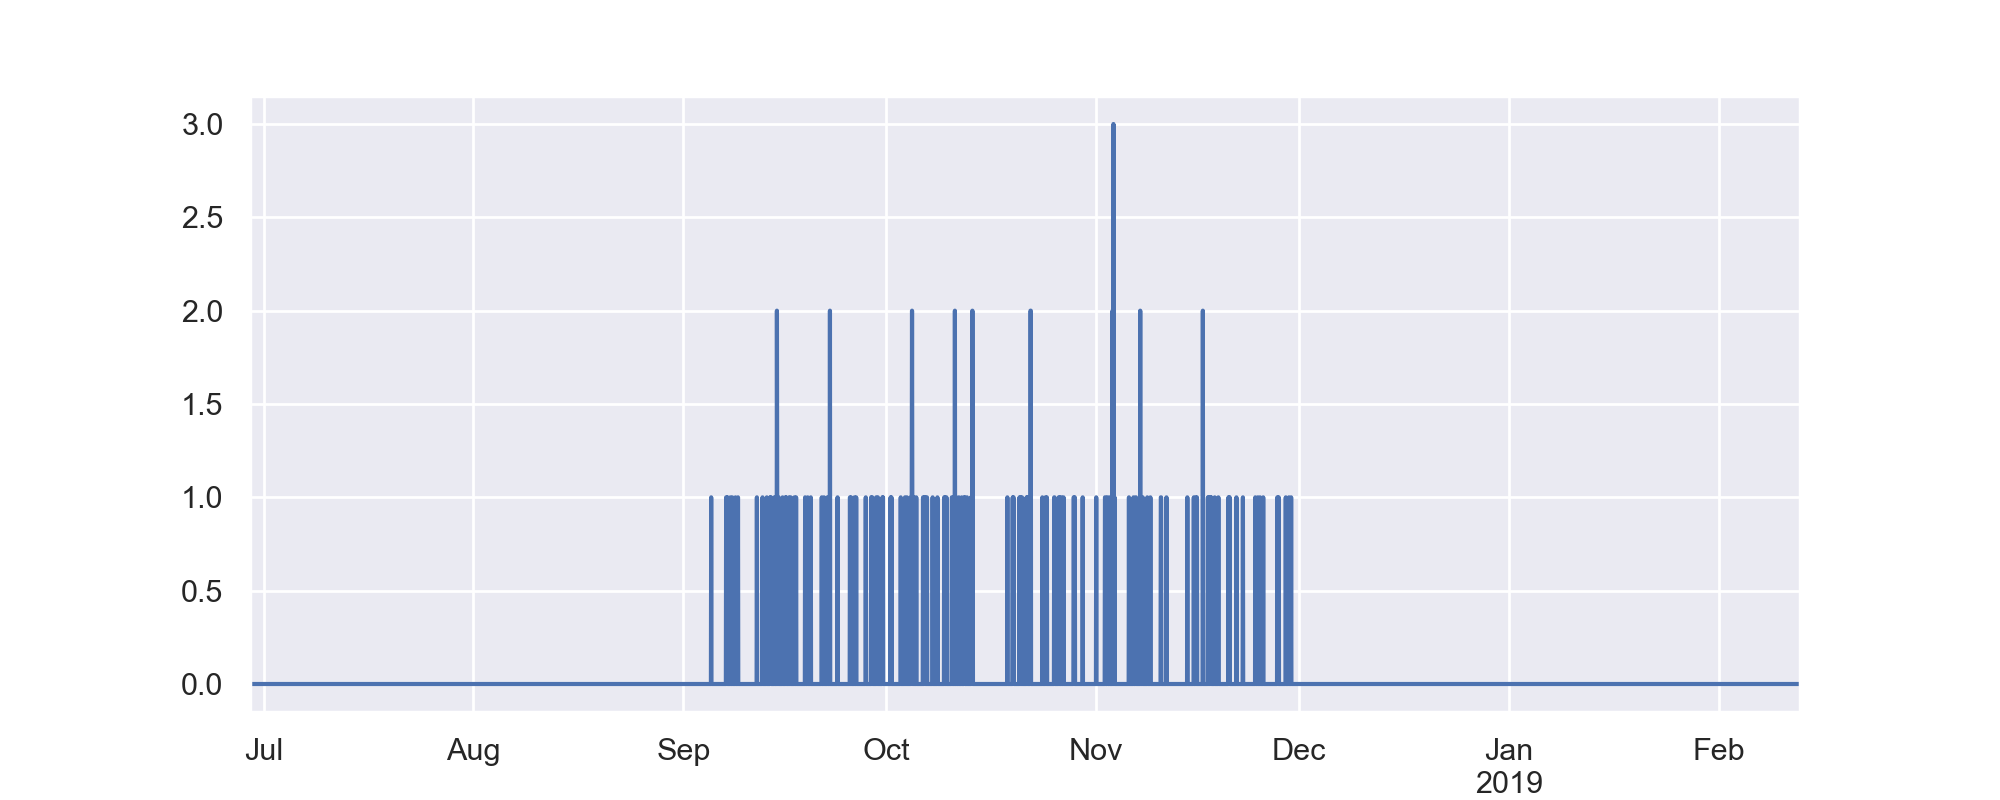

In [70]:
date_rng = pd.date_range(start='6/29/2018', end='2/12/2019').tolist()
date_rng_hourly = pd.date_range(start='6/29/2018', end='2/13/2019', freq='H', closed='left').tolist()
hourly_accidents = pd.DataFrame(date_rng_hourly, columns=['date'])
hourly_accidents = hourly_accidents.set_index('date')

%matplotlib notebook
hourly_accidents['accidents'] = accident_counts
hourly_accidents['accidents'].plot()

In [41]:
df2 = df1.join(hourly_accidents, how='outer')
df2 = df2.dropna()

## Plot accidents and precipitation

<IPython.core.display.Javascript object>


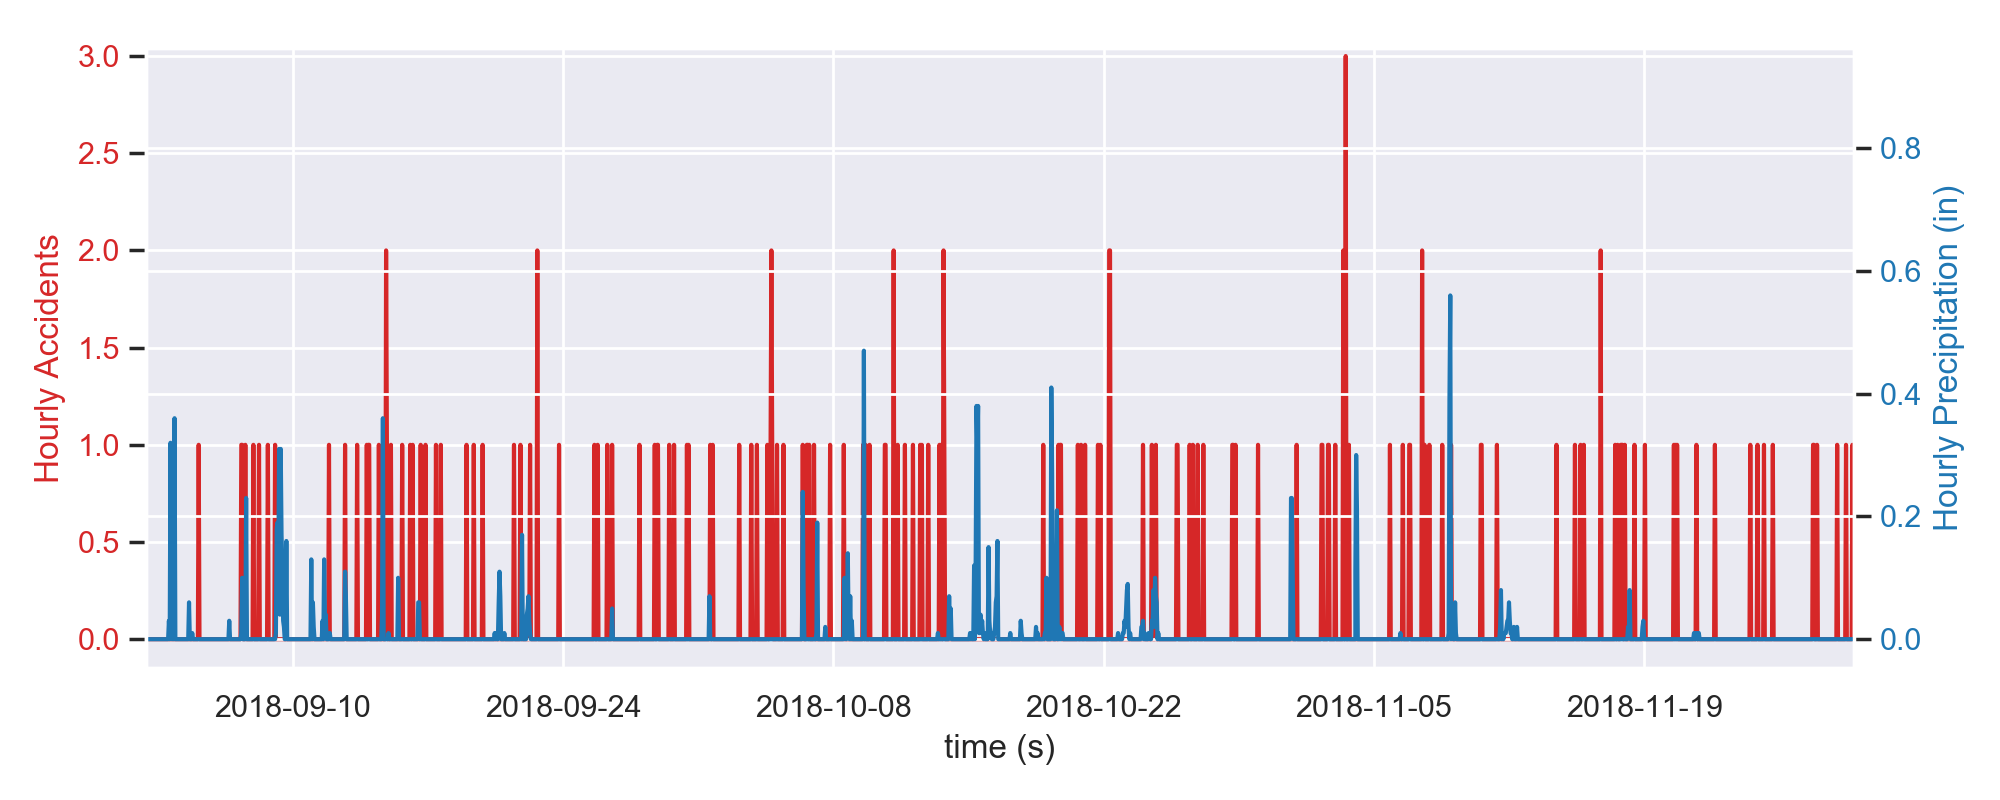

In [71]:
%matplotlib notebook
data1 = df2['accidents']
data2 = df2['Precip (in)']
t = df1.index

fig, ax1 = plt.subplots()
# ax1.set_facecolor('white')

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Hourly Accidents', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Hourly Precipitation (in)', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### In many cases, it appears that an accident occurrs during or shortly after periods of precipitation. However, there are many accidents that do not occurr during periods of precipitation.

<IPython.core.display.Javascript object>


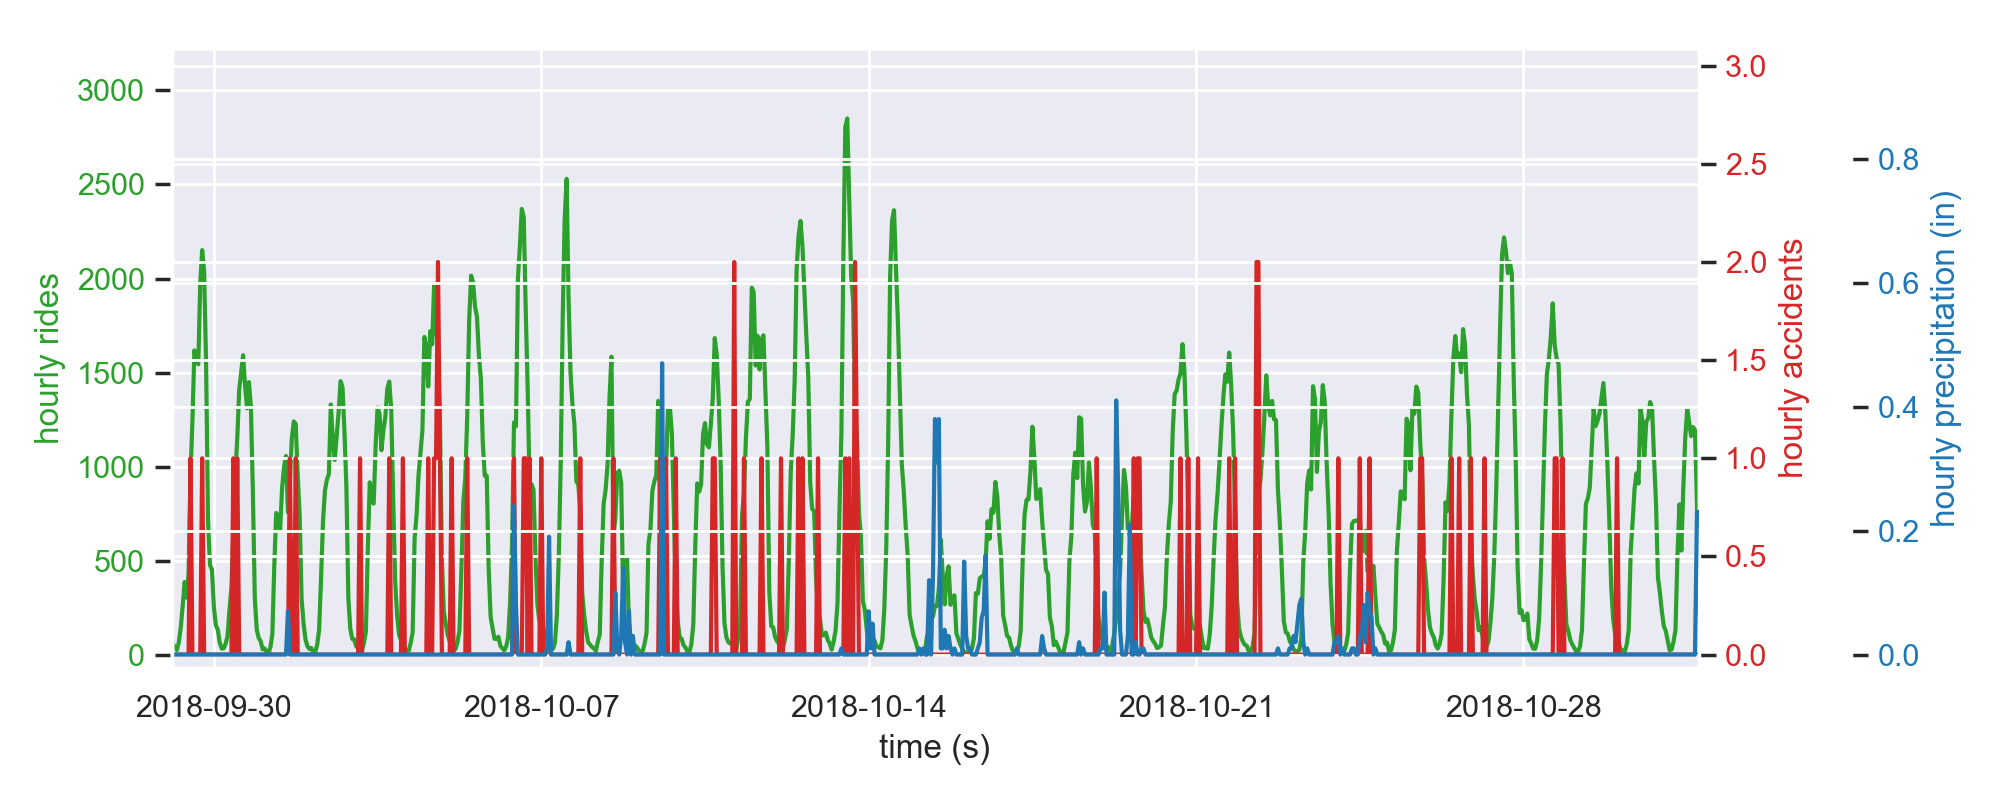

In [72]:
%matplotlib notebook
data1 = df2['ridecount']
data2 = df2['accidents']
data3 = df2['Precip (in)']
t = df1.index

fig, ax1 = plt.subplots()
# ax1.set_facecolor('white')

color = 'tab:green'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('hourly rides', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('hourly accidents', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))

color = 'tab:blue'
ax3.set_ylabel('hourly precipitation (in)', color=color)
ax3.plot(t, data3, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()